#### Anomaly Detection - Imports and Setup

In [70]:
%reload_ext autoreload
%autoreload 2
import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Lambda, Dropout, SimpleRNN, Dense, LSTM, RepeatVector, Input, TimeDistributed, concatenate
from keras import regularizers
from keras.utils import plot_model

import IPython, IPython.display, os, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mpl.rcParams['figure.figsize'] = (14, 4)
mpl.rcParams['axes.grid'] = True

print(f"Tensorflow Version {tf.__version__}, Keras Vesion: {keras.__version__}")

Tensorflow Version 2.10.0, Keras Vesion: 2.10.0


In [180]:
import ts_utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle

# STEP 1: = >Lets just read the first few columns for testing
df = pd.read_csv("../data/processminer-rare-event-mts.csv.zip", sep=';', usecols=range(59))
split = int (.8 * len(df) )
df_scaled_trn = df [df.columns[2:] ][0:split ]
df_scaled_tst = df [df.columns[2:] ][split: ]

scaler = MinMaxScaler()
df_scaled_trn = pd.DataFrame(scaler.fit_transform(df_scaled_trn), columns=df_scaled_trn.columns)
df_scaled_tst = pd.DataFrame(scaler.transform(df_scaled_tst), columns=df_scaled_tst.columns)


#  STEP 2: => Create window

input_slice  = slice(0, len(df_scaled_trn.columns) )
label_slice  = input_slice
window_len   = 5
ouput_len    = 1
batch_size   = 128

inp_feat_len   = input_slice.stop - (input_slice.start or 0)
ouput_feat_len = label_slice.stop - (label_slice.start or 0)

ds_trn     = tf.data.Dataset.from_tensor_slices(df_scaled_trn[df_scaled_trn.columns[input_slice]])
ds_tst     = tf.data.Dataset.from_tensor_slices(df_scaled_tst[df_scaled_trn.columns[input_slice]])
window_trn = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=batch_size, for_aencoder=1)
window_tst = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=batch_size, for_aencoder=1)

window_trn100 = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=100000, for_aencoder=1)
window_tst100 = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=100000, for_aencoder=1)

display( pd.concat([df, df_scaled_trn], axis=1))
#for w in window_trn.take(1): print(f'{w[0]} \n\n {w[1]}' )

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,0.587033,0.468376,0.841714,0.997247,0.979771,0.562500,0.038030,0.397786,0.551731,0.823712
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,0.587064,0.470738,0.841608,0.997247,0.979791,0.562875,0.037965,0.382678,0.559875,0.783305
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,0.587094,0.476883,0.841501,0.997247,0.979813,0.563251,0.037899,0.379259,0.568019,0.826988
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,0.587125,0.476006,0.841395,0.997247,0.979835,0.563617,0.037834,0.375840,0.557788,0.849920
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,0.587155,0.475128,0.841288,0.997247,0.979856,0.563992,0.037769,0.372421,0.558239,0.830264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,5/28/99 23:58,0,-0.877441,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18394,5/29/99 0:00,0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18395,5/29/99 0:02,0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18396,5/29/99 0:04,0,-0.822843,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Model: "Simple_LSTM_AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 5, 32)             11520     
                                                                 
 lstm_41 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_10 (RepeatVec  (None, 5, 16)            0         
 tor)                                                            
                                                                 
 lstm_42 (LSTM)              (None, 5, 16)             2112      
                                                                 
 lstm_43 (LSTM)              (None, 5, 32)             6272      
                                                                 
 time_distributed_10 (TimeDi  (None, 5, 57)            1881      
 stributed)                                         

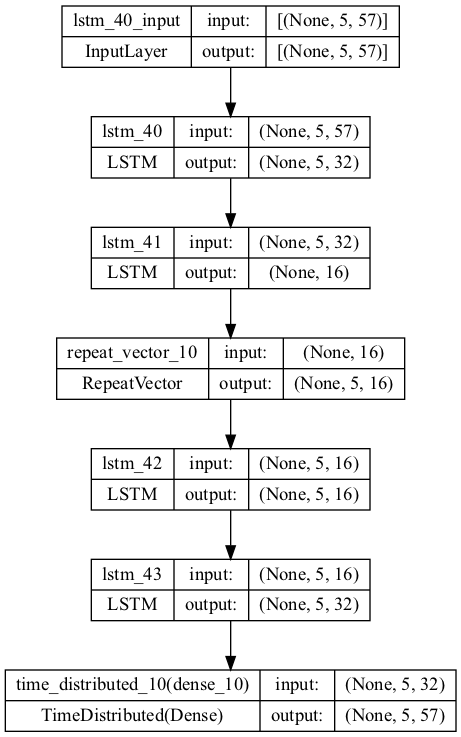

In [181]:
from keras.utils import plot_model

lstm_ae1 = Sequential(name="Simple_LSTM_AE")
# Encoder
lstm_ae1.add(LSTM(32, activation='relu', input_shape=(window_len, inp_feat_len), return_sequences=True))
lstm_ae1.add(LSTM(16, activation='relu', return_sequences=False))
lstm_ae1.add(RepeatVector(window_len))
# Decoder
lstm_ae1.add(LSTM(16, activation='relu', return_sequences=True))
lstm_ae1.add(LSTM(32, activation='relu', return_sequences=True))
lstm_ae1.add(TimeDistributed(Dense(inp_feat_len)))

lstm_ae1.summary()

plot_model(lstm_ae1, show_shapes=True)


In [243]:
dim = 128

# Create Autoencoder Layer
input_layer = Input(shape=(window_len, inp_feat_len), dtype='float32', name='input')
memory_layer = LSTM(dim, return_sequences=True)(input_layer)
memory_layer = LSTM (int(dim//2), return_sequences=False)(memory_layer)
repeated_lyr = RepeatVector(window_len)(memory_layer)
memory_layer = LSTM (int(dim//2), return_sequences=True)(repeated_lyr)
memory_layer = LSTM (dim,  return_sequences=True)(memory_layer)
decoded_inputs = TimeDistributed(Dense(units=inp_feat_len, activation='linear'))( memory_layer)

dropout_input = Dropout(0.2)(input_layer)
concat_layer = concatenate([dropout_input, decoded_inputs])
memory_layer = LSTM(units=dim, 
                    kernel_regularizer = regularizers.l1_l2(l1= .1, l2= .1), 
                    recurrent_regularizer = regularizers.l1_l2(l1= .1, l2= .1), 
                    return_sequences=False)(concat_layer)
preds = Dense(units=inp_feat_len, activation='linear')(memory_layer)

umodel = Model(input_layer, preds)
#umodel.summary()

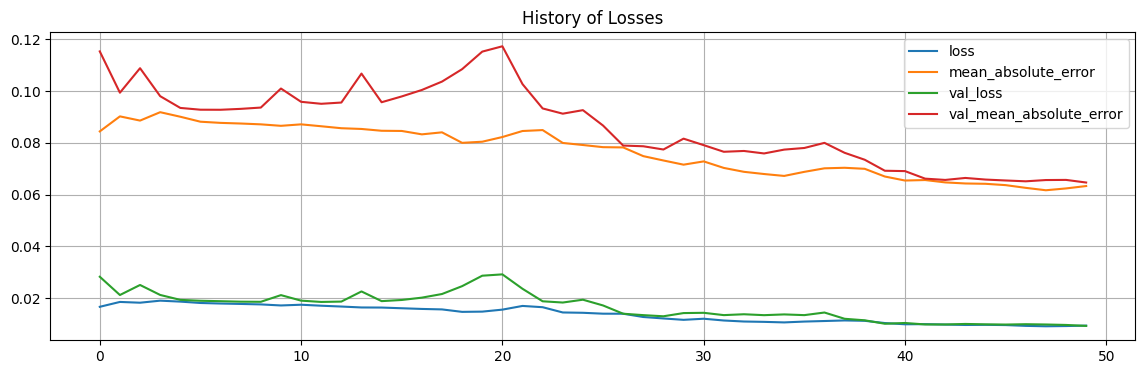

In [245]:
model = lstm_ae1
#model = umodel
history = ts_utils.compile_fit(model, window_trn, window_tst= window_trn, patience=30, epochs=50)

IPython.display.clear_output()

for l in history.history:
    plt.plot(history.history[l], label=f"{l}")
plt.title("History of Losses")
plt.legend()

### Anomaly - precision/Recall etc.

460/460 [==============================] - 1s 2ms/step


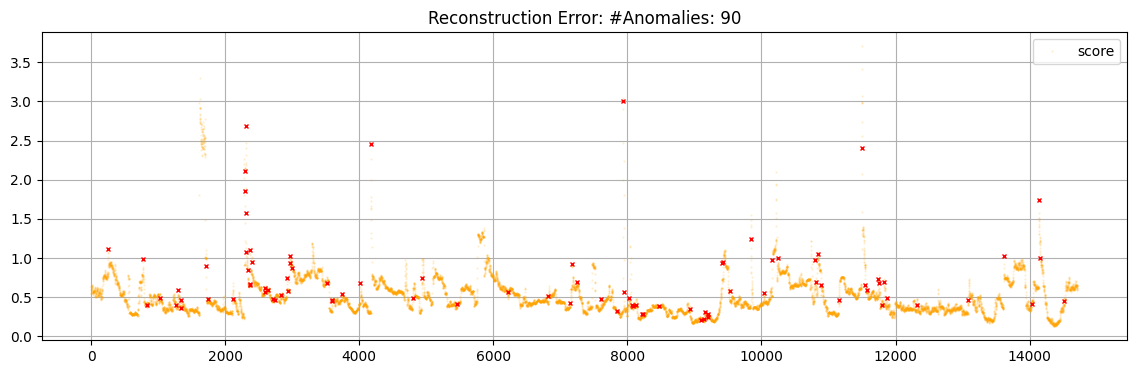

In [249]:
model = lstm_ae1

for w in window_trn100:
    p = model.predict(w[0])
    
e = np.mean((p - w[0])**2, axis=1)
m = np.sum(e, axis=1)

y= df.y[0:len(e)]
yy = [np.nan if j<1 else m[i] for i,j in enumerate(y)]

plt.plot(range(len(e)), m, alpha=0.2, c='orange', marker='o', label="score", linestyle='', markersize=.5);
plt.plot(yy, marker='x', c="red" , linestyle="", markersize=3)

plt.title(f"Reconstruction Error: #Anomalies: {sum(y)}")
plt.legend();


115/115 [==============================] - 0s 2ms/step


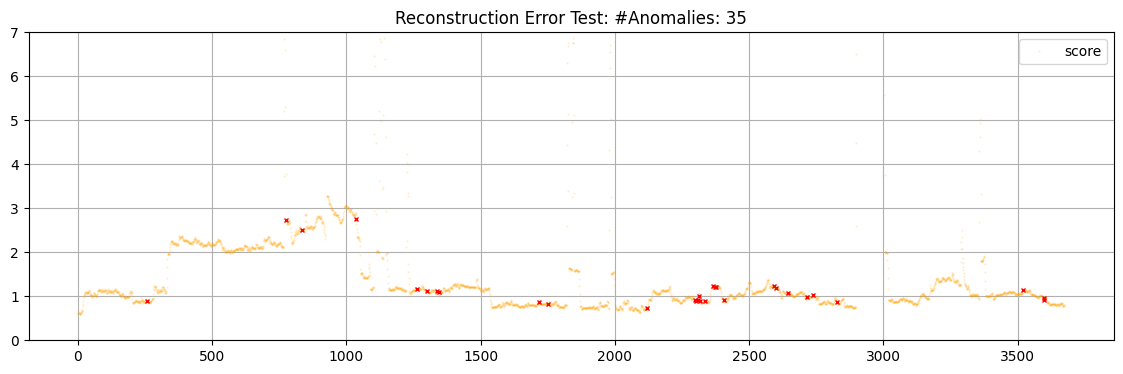

In [250]:
for w in window_tst100:
    p = model.predict(w[0])
    
et = np.mean((p - w[0])**2, axis=1)
mt = np.sum(et, axis=1)

yt= df.y[0:len(et)]
yy = [np.nan if j<1 else mt[i] for i,j in enumerate(yt)]

plt.plot(range(len(et)), mt, alpha=0.2, c='orange', marker='o', label="score", linestyle='', markersize=.5);
plt.plot(yy, marker='x', c="red" , linestyle="", markersize=3)

plt.title(f"Reconstruction Error Test: #Anomalies: {sum(yt)}")
plt.ylim(0,7)
plt.legend();


###  Precision Recall Curves

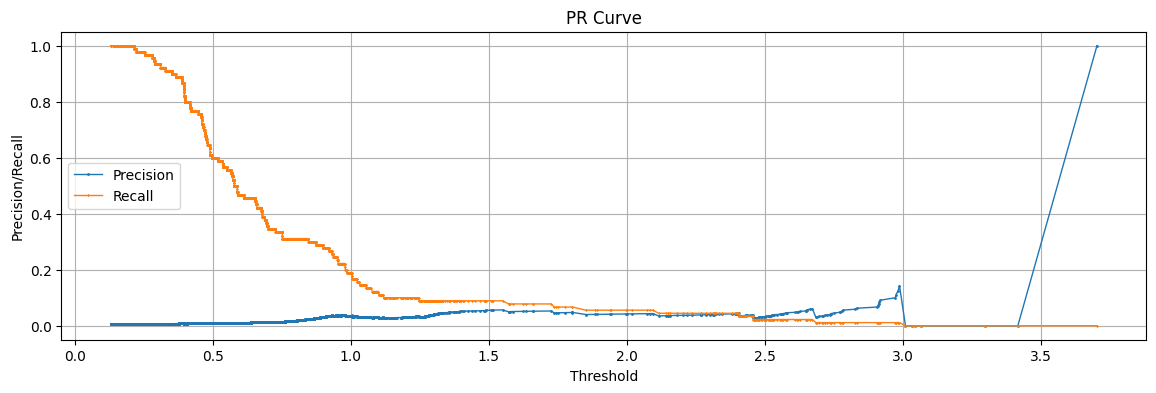

In [323]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score


prec, recall, thr = precision_recall_curve(y, m)
plt.plot(thr, prec[1:],   label="Precision", marker='o', linewidth=1, markersize=1)
plt.plot(thr, recall[1:], label="Recall",    marker='x', linewidth=1, markersize=1)
plt.title('PR Curve')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
#plt.xlim(2,2.5)
#plt.ylim(0,.2)


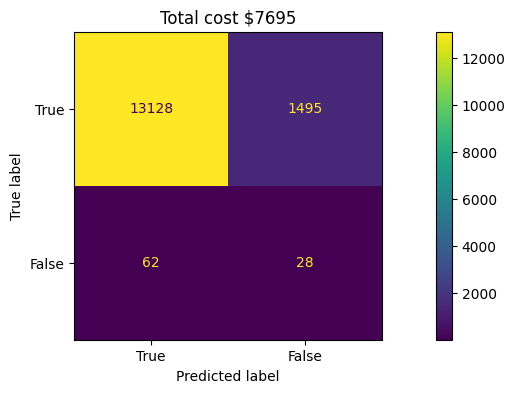

In [324]:
THRESHOLD = 0.8
yhat = [1 if e > THRESHOLD else 0 for e in m]
cm = confusion_matrix(y, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True", "False"])

cost_fp= 1      # Cost of False Positive
cost_fn= 100    # Cost of False Negative

tcost = cm[0,1] * cost_fp +  cm[1,0] * cost_fn

disp.plot()
plt.title(f"Total cost ${tcost}")
plt.grid(0)


Total cost $6638
